In [1]:
# Import libraries and packages
import os
import pandas as pd
import numpy as np

# Define path with .py codes containing functions used in this script
os.getcwd()
os.chdir( '../src/features')

# Import useful functions for this script  
from tracking import track
import matplotlib.pyplot as plt

# Reading data
#### Define path to data files

In [2]:
track("Defining path to data files")

# Define base path to data files
path = '../../temp_data/'

# Define path to the model_data_with_clusters table
path_clusters_data = path + 'model_data_with_clusters.csv'

# Ensure the input file exist
assert os.path.isfile(path_clusters_data), f'{path_clusters_data} not found. Is it a file?'

#### Read the files

In [3]:
track("Reading files")

# Read clusterized data 
clusterized_data = pd.read_csv(path_clusters_data)

track("Finished reading files")

# Validation

In [4]:
average_quality = (clusterized_data.groupby('clusters').agg(blocker_violations_mean = ('blocker_violations', 'mean'),
                                          blocker_violations_std = ('blocker_violations', 'std'),
                                          critical_violations_mean = ('critical_violations', 'mean'),
                                          critical_violations_std = ('critical_violations', 'std'),
                                          major_violations_mean = ('major_violations', 'mean'),
                                          major_violations_std = ('major_violations', 'std'),
                                          minor_violations_mean = ('minor_violations', 'mean'),
                                          minor_violations_std = ('minor_violations', 'std'),
                                          code_smells_mean = ('code_smells', 'mean'),
                                          code_smells_std = ('code_smells', 'std'),
                                          bugs_mean = ('bugs', 'mean'),
                                          bugs_std = ('bugs', 'std'),
                                          vulnerabilities_mean = ('vulnerabilities', 'mean'),
                                          vulnerabilities_std = ('vulnerabilities', 'std'),
                                          blocker_mean = ('blocker', 'mean'),
                                          blocker_std = ('blocker', 'std'),
                                          critical_mean = ('critical', 'mean'),
                                          critical_std = ('critical', 'std'),
                                          major_mean = ('major', 'mean'),
                                          major_std = ('major', 'std'),
                                          minor_mean = ('minor', 'mean'),
                                          minor_std = ('minor', 'std'))).reset_index()

In [5]:
quality_rating_data = clusterized_data.groupby('clusters').agg({
    'violations': 'sum',
                            'blocker_violations': 'sum',
                            'critical_violations': 'sum',
                            'major_violations': 'sum',
                            'minor_violations': 'sum',
                            'blocker': 'sum',
                            'critical': 'sum',
                            'major': 'sum',
                            'minor': 'sum',
                            'code_smells': 'sum',
                            'bugs': 'sum',
                            'vulnerabilities': 'sum',
                            'sqale_debt_ratio': 'mean',
}).reset_index()
quality_rating_data.head()

# Calculate ponderated mean of the violations variables
violations = quality_rating_data[["blocker_violations", "critical_violations", "major_violations", "minor_violations"]] 
violations = violations*[0.5, 0.4, 0.07, 0.03]
violations = np.sum(violations, axis=1)
# Calculate ponderated mean of the severity issues variables
severity = quality_rating_data[["blocker", "critical", "major", "minor"]]
violations = violations*[0.5, 0.4, 0.15, 0.05]
severity = np.sum(severity, axis=1)
# Add violations and severity columns in the dataset
quality_rating_data['violations'] = violations
quality_rating_data['severity'] = severity
# Discard all types of violations and severity issues columns
quality_rating_data = quality_rating_data.drop(["clusters", "blocker_violations", "critical_violations", "major_violations", "minor_violations", "blocker", "critical", "major", "minor"], axis=1)
quality_rating_data
# Compute the mean of each cluster
quality_rating_data = quality_rating_data[["violations", "code_smells",	"bugs",	"vulnerabilities",	"severity"]]
quality_rating_data
suma = np.sum(quality_rating_data, axis=1)

total = np.sum(suma)
quality_rating = suma/total
quality_rating

0    0.073888
1    0.611608
2    0.198012
3    0.116492
dtype: float64

In [6]:
FONTSIZE = 30
FIG_WIDTH = 38
FIG_HEIGHT = 15

In [7]:
def save_plot(fig,filename):
    '''
    Objective:
        - Save plots
    Input:
        - fig: figure we want to save
        - filename: Name of the file 
    Output:
        - None
    '''

    # Path and name of the file/figure we want to save
    path = '../../reports/figures/validation'+"/"
    file_name = path+"/"+filename+".png"
    # Directory creation if doesn't exists
    try:
        os.makedirs(path)
    except OSError:
        pass
    else:
        track("Successfully created the directory %s" % path)

    # Save the figure/file
    if (os.path.exists(file_name)== True):
        track ("Warning: Figure %s already created" % path)
        track('Figure will be overwritten')
        plt.savefig(file_name, transparent=True)
    else:
        plt.savefig(file_name, transparent=True)
    track("Successfully saved %s" % path)

def plot_quality_metrics(df, metrics, yticks):
    '''
    Objective:
        - To plot the metric values for each cluster
    Input:
        - df: dataframe 
        - metrics: selected columns of the dataframe to be plotted
        - yticks: y-axis values to be printed in the plot
    Output:
        - Plot: plots the metric values for each cluster to compare among them
    '''
    fgr = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    for metric in metrics:
        markers, caps, bars = plt.errorbar(range(len(df)), df[metric + '_mean'], df[metric + '_std'],
                                        label=metric,  fmt='--o', markersize=15, elinewidth=6)
        [bar.set_alpha(0.4) for bar in bars]
        [cap.set_alpha(0.4) for cap in caps]

    plt.title('Quality of each cluster', fontsize = FONTSIZE)
    plt.xlabel('Cluster', fontsize = FONTSIZE)
    plt.ylabel('Metric value', fontsize = FONTSIZE)
    plt.xticks(ticks=range(len(df)), labels=df["clusters"], fontsize = FONTSIZE)
    plt.yticks(ticks = yticks, fontsize=FONTSIZE)
    plt.legend(metrics, bbox_to_anchor=(1.001,0.8), prop={'size': FONTSIZE})
    plt.grid()
    if metrics[0] == "blocker_violations":
        save_plot(fgr, "violations")
    elif metrics[0] == "blocker":
        save_plot(fgr, "severity_issues")
    else: 
        save_plot(fgr, "issues_types")
    plt.show()
    plt.close()

In [8]:
# There will be three different plots. It is necessary to create the groups of the variables to be printed in the same plot 
violation_metrics = ["blocker_violations", "critical_violations", "major_violations", "minor_violations"]
severity_metrics = ["blocker", "critical", "major", "minor"]
other_metrics = ["code_smells", "bugs", "vulnerabilities"]

In [9]:
# Order the quality rating from the best cluster to the words one. It allows to compare the values from the cluster with highest quality rating to the lowest one.
average_quality['quality_rating'] = quality_rating
sorted_average_quality = average_quality.sort_values(by=['quality_rating'],ascending = False)

In [10]:
sorted_average_quality

,clusters,blocker_violations_mean,blocker_violations_std,critical_violations_mean,critical_violations_std,major_violations_mean,major_violations_std,minor_violations_mean,minor_violations_std,code_smells_mean,...,vulnerabilities_std,blocker_mean,blocker_std,critical_mean,critical_std,major_mean,major_std,minor_mean,minor_std,quality_rating
1,1,257.767142,14.329385,2042.587349,248.941404,16455.671070,1956.799055,24902.529851,2960.287473,43012.174833,...,86.737953,14.423077,29.725643,74.769231,162.856822,854.423077,1787.570870,700.692308,1536.499730,0.611608
2,2,67.900901,71.915628,457.153873,268.236517,3361.255005,2500.106253,3817.461652,3402.847779,7468.697793,...,178.783684,1.625000,3.380954,16.229167,30.860868,120.000000,237.728882,116.166667,245.892498,0.198012
3,3,17.385059,38.633119,262.377697,249.510481,920.372784,814.297537,807.685344,813.262676,1995.142772,...,65.442900,0.811321,2.480834,13.971698,69.751731,74.292453,225.950815,54.820755,144.427592,0.116492
0,0,27.724120,46.212292,169.032645,149.035588,643.216901,473.728300,674.852063,524.945713,1503.822798,...,24.562588,2.828125,5.241939,55.578125,135.644119,349.171875,781.537365,297.421875,662.757103,0.073888


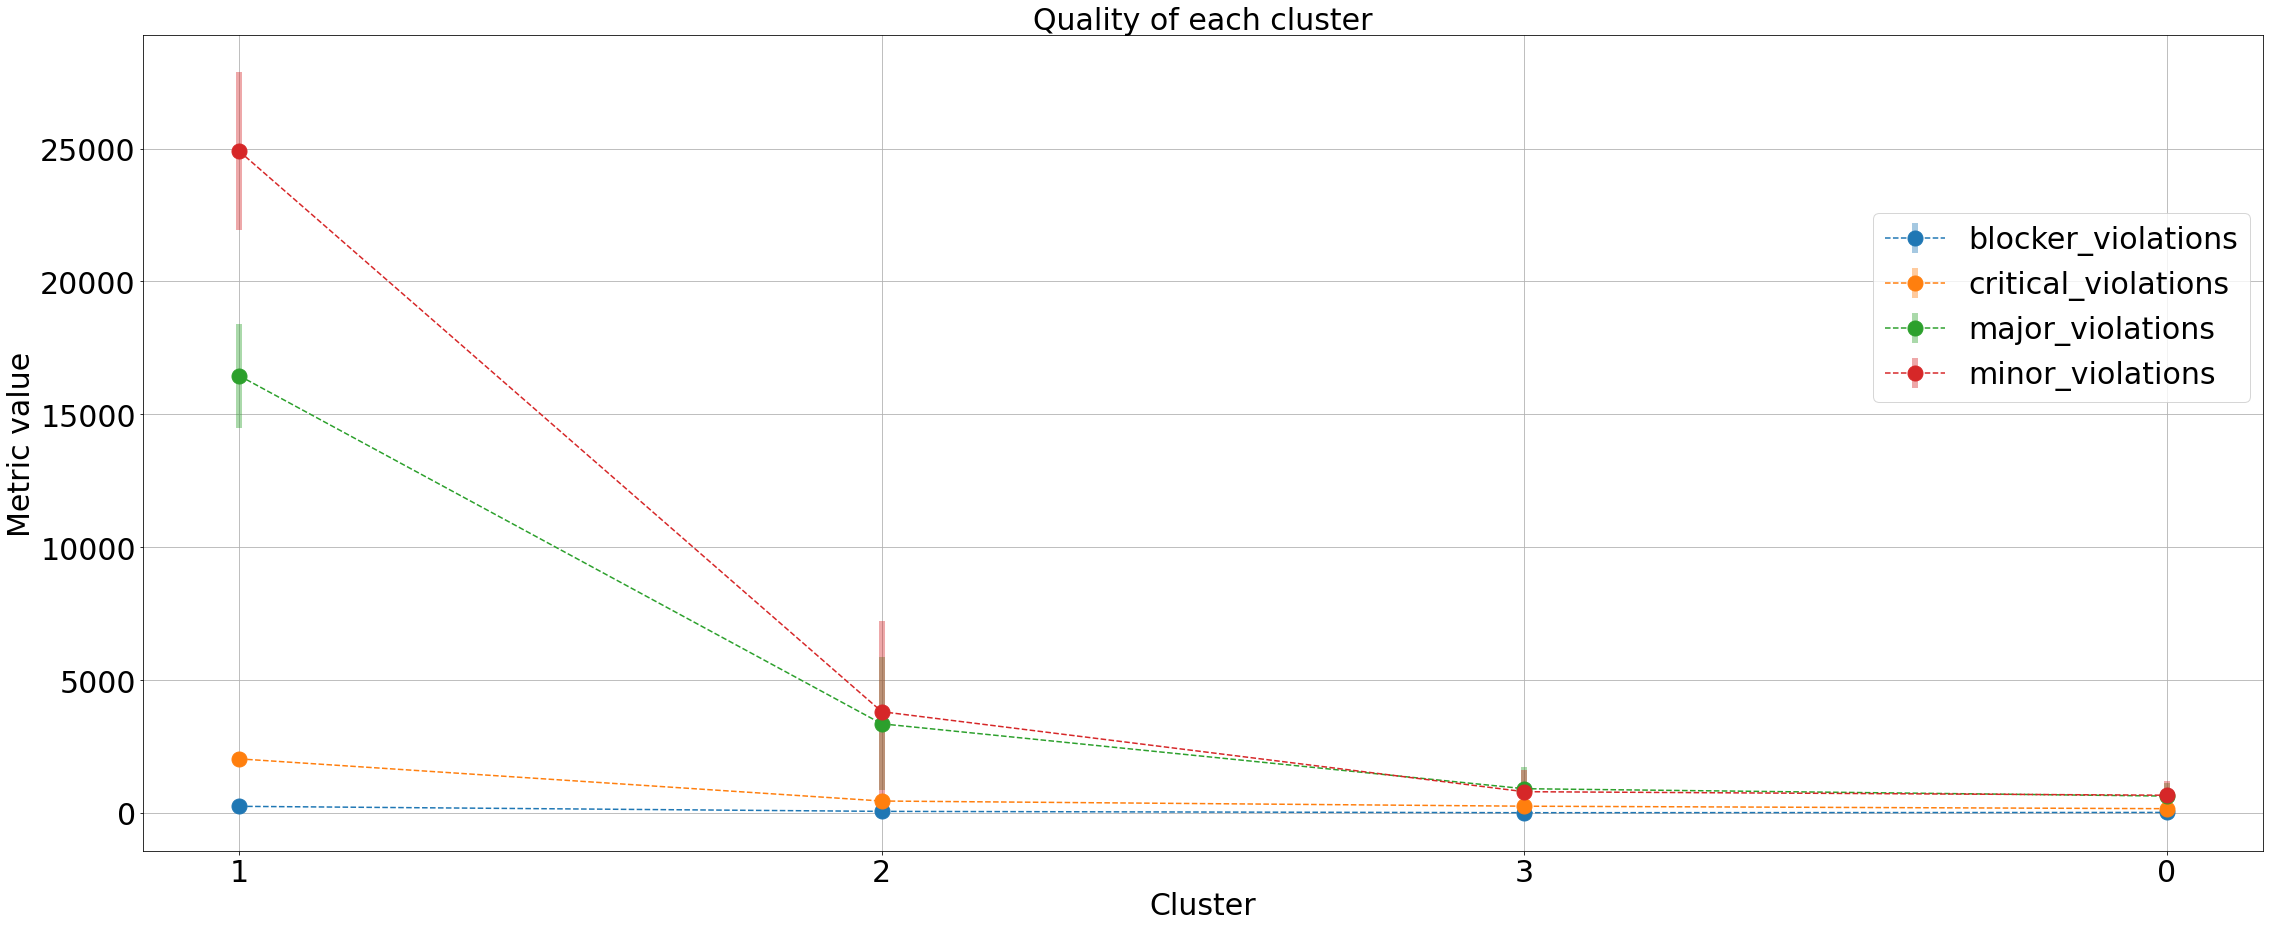

In [11]:
plot_quality_metrics(sorted_average_quality, violation_metrics, [0, 5000, 10000, 15000, 20000, 25000])

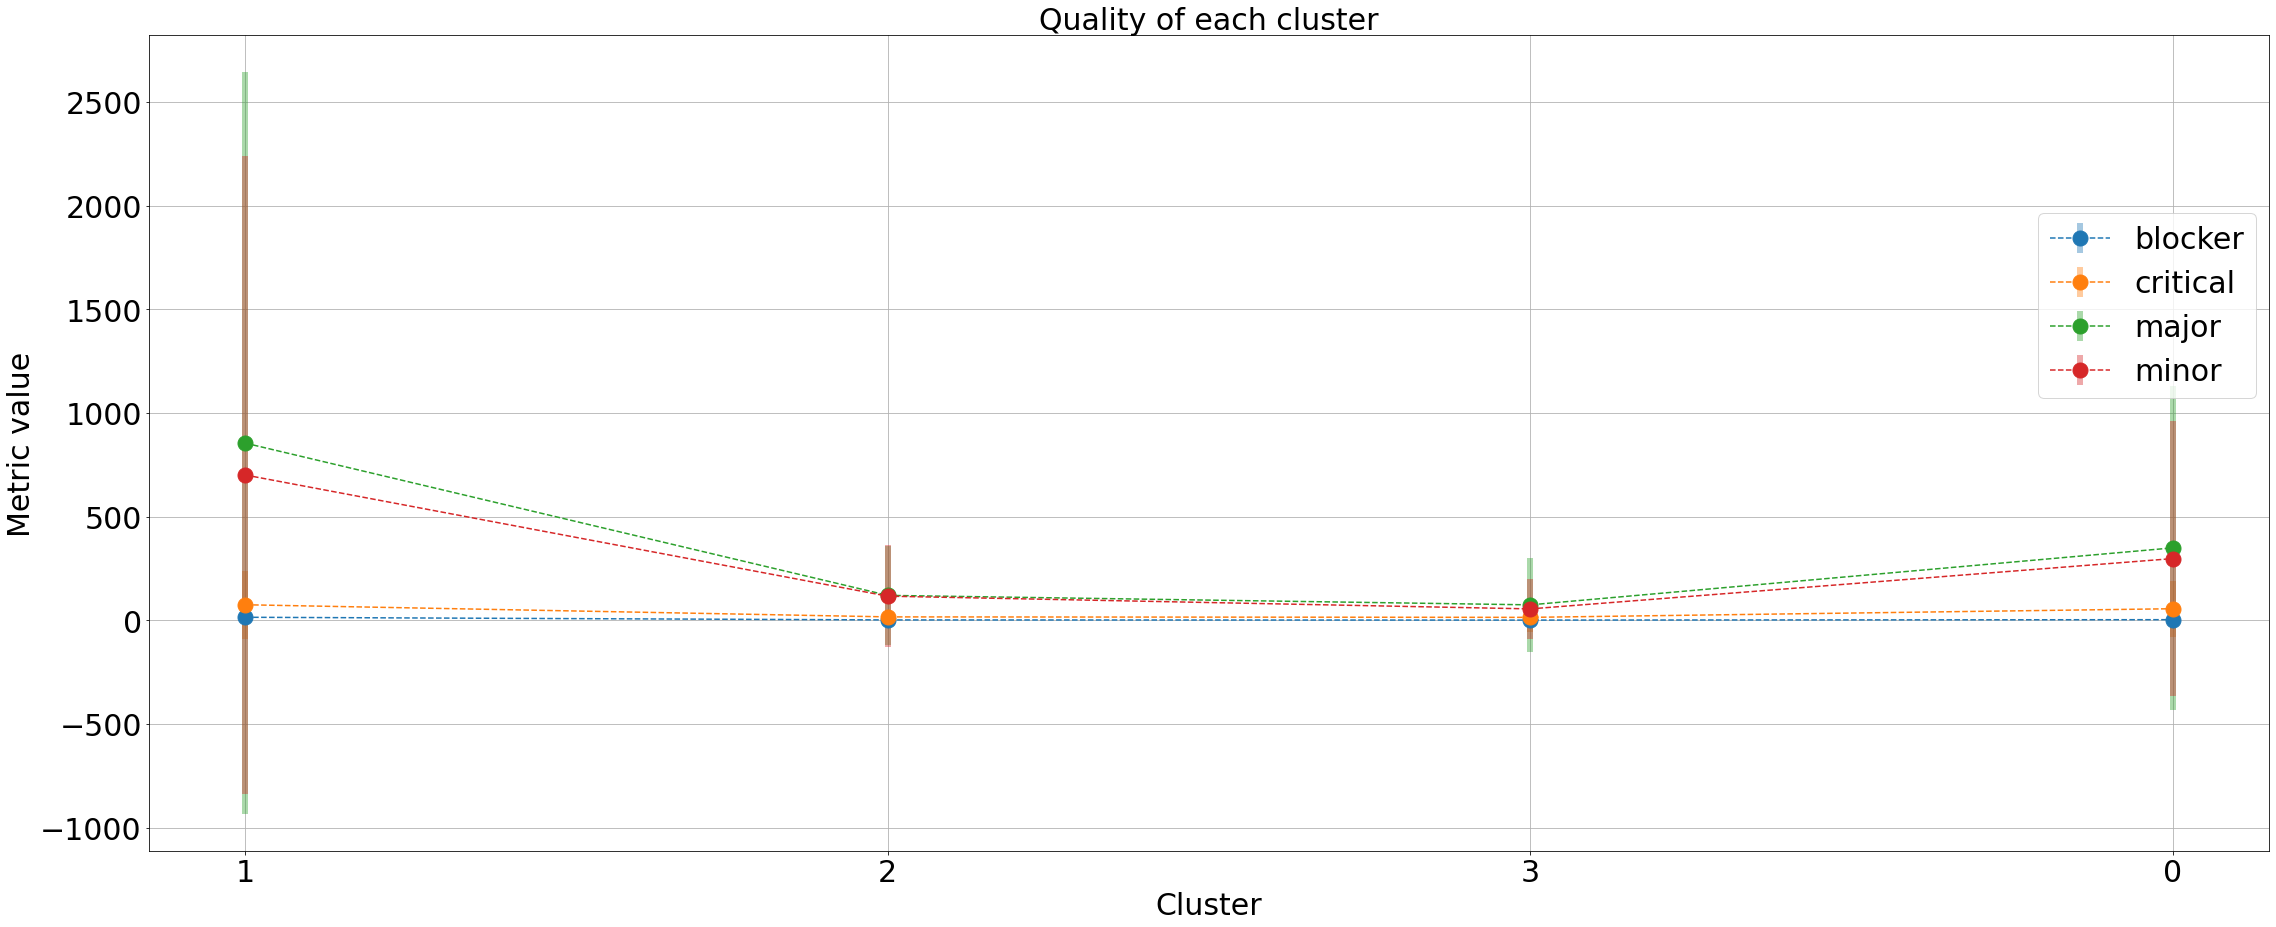

In [12]:
plot_quality_metrics(sorted_average_quality, severity_metrics, [-1000, -500, 0, 500, 1000, 1500, 2000, 2500])

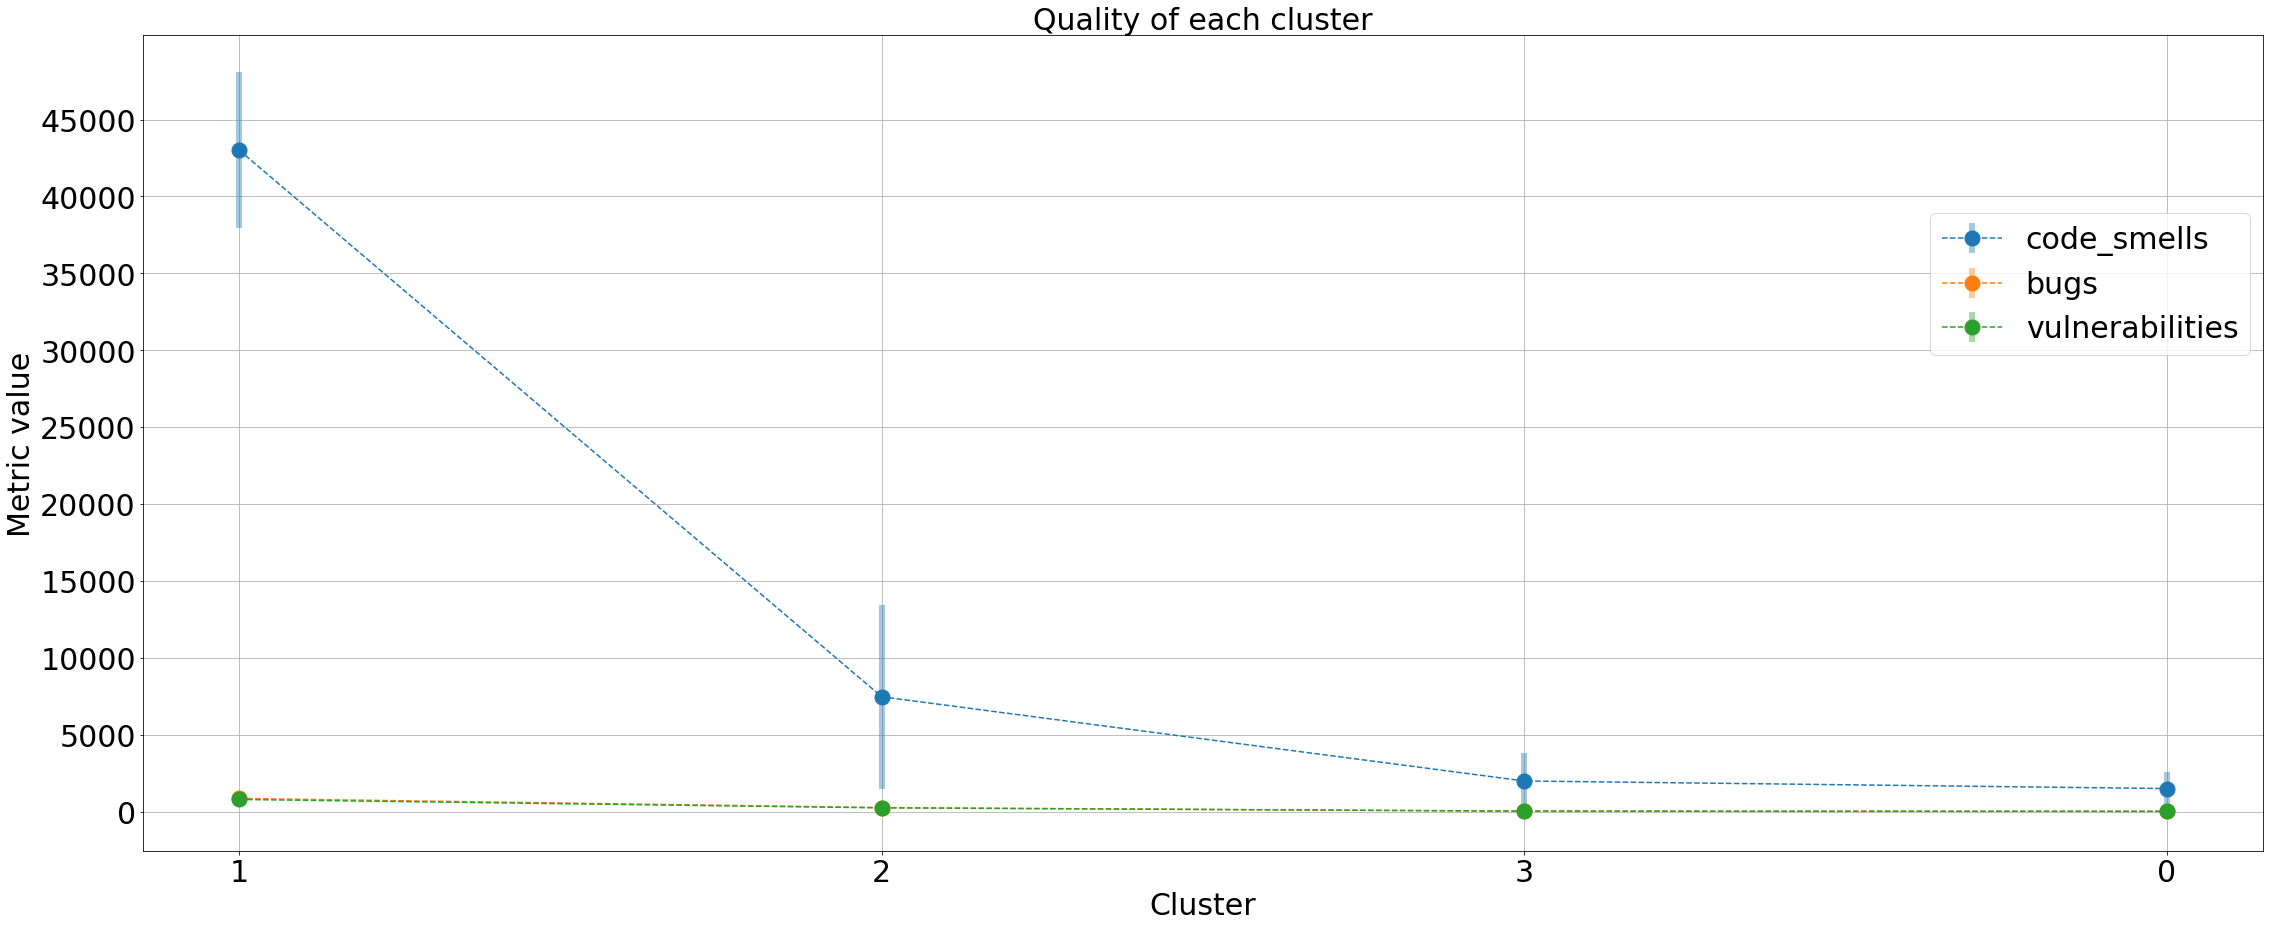

In [13]:
plot_quality_metrics(sorted_average_quality, other_metrics, [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000])